In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import re
from sentence_transformers import SentenceTransformer
from langdetect import detect


# Options
sns.set_theme(style='dark')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
#load the data
raw_data = pd.read_csv(
    "../data/raw/aa_dataset-tickets-multi-lang-5-2-50-version.csv")

#combine subject + body into a single text field
raw_data["analysis_text"] = raw_data["subject"].fillna('') + " " + raw_data["body"].fillna('')

#use langdetect to find the true language
raw_data["detected_language"] = raw_data["analysis_text"].apply(lambda x: detect(x))

# Only keep English tickets for analysis
english_data = raw_data[raw_data['detected_language'] == 'en']

#combine queues based on the analysis
english_data = english_data.copy()
english_data.loc[:, 'updated_queue'] = english_data['queue'].replace({
    'Technical Support': 'Technical & IT Support',
    'IT Support': 'Technical & IT Support',
    'Customer Service': 'Customer Service, Returns & Exchanges',
    'Returns and Exchanges': 'Customer Service, Returns & Exchanges'
})

The block of code above repeats from a previous notebook since the code repeats it will be converted to a function and push to the main branch.

##### Proof of Concept: Class Separability 
- How well does a simple classifer with embeddings perform at distinguishing queues — check confusion matrix to find overlap.

In [3]:
#label encode target
label_encoder = LabelEncoder()
english_data["queue_encoded"] = label_encoder.fit_transform(english_data["updated_queue"])

In [4]:
#load pre-trained embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

In [5]:
#generate embeddings
embeddings = embedding_model.encode(english_data["analysis_text"].tolist())

#### Model Building: Predict Queue Using Text Embeddings

In [6]:
#split dataset
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, 
    english_data["queue_encoded"], 
    test_size=0.2, 
    stratify=english_data["queue_encoded"], 
    random_state=42
)

In [7]:
#simple classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [8]:
#evaluation
y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test,y_pred, target_names=label_encoder.classes_))

Classification Report:
                                       precision    recall  f1-score   support

                 Billing and Payments       0.96      0.71      0.82       384
Customer Service, Returns & Exchanges       0.64      0.56      0.60       777
                      General Inquiry       1.00      0.22      0.36        55
                      Human Resources       1.00      0.23      0.37        80
                      Product Support       0.82      0.42      0.55       729
                  Sales and Pre-Sales       1.00      0.17      0.29       120
      Service Outages and Maintenance       0.90      0.40      0.55       160
               Technical & IT Support       0.63      0.95      0.75      1629

                             accuracy                           0.68      3934
                            macro avg       0.87      0.46      0.54      3934
                         weighted avg       0.73      0.68      0.66      3934



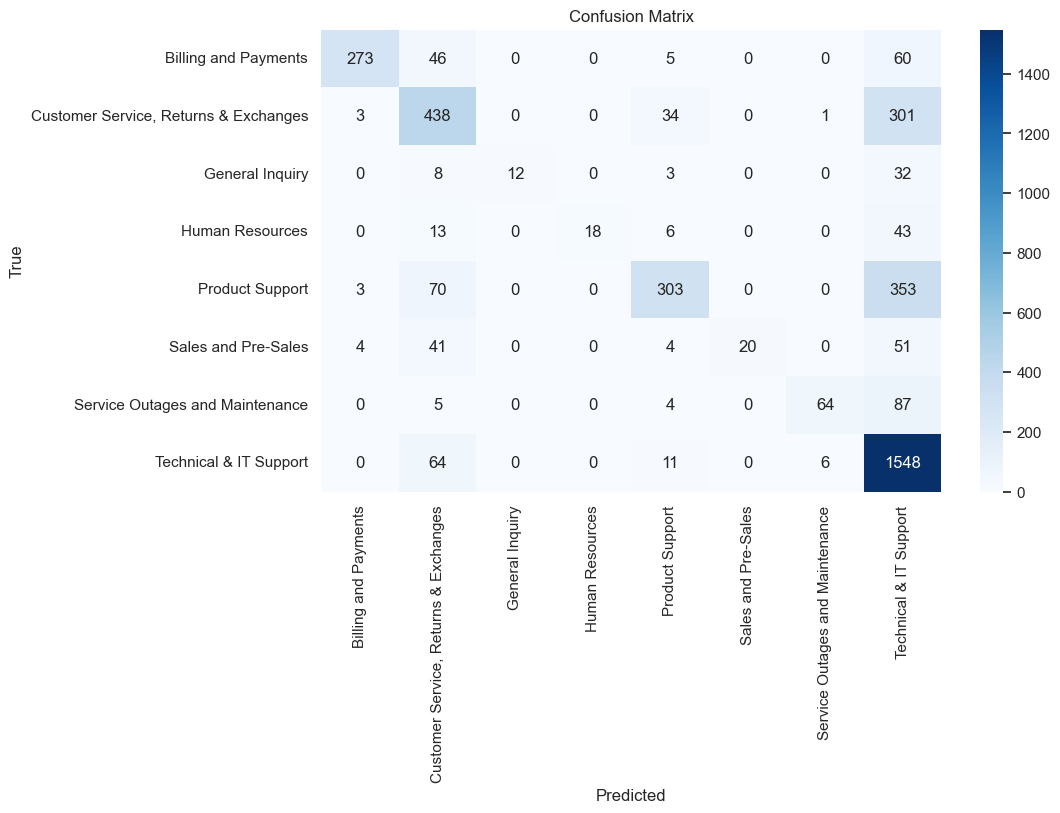

In [9]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))

sns.heatmap(cm,
annot=True,
fmt="d", 
xticklabels=label_encoder.classes_, 
yticklabels=label_encoder.classes_, 
cmap="Blues")

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

This is a proof-of-concept model with no preprocessing or feature engineering, but still achieves a 66% overall weighted F1-Score. The model performs well with the `Technical & IT Support` queue; the model correctly identifies tickets belonging to this queue 95% of the time. The model also performed well with the `Billing & Payments` queue with an F1-score of 83%.

The model misclassified 288 `Customer Service, Returns & Exchanges` tickets as `Technical & IT Support` - there's probably some overlapping vocabulary between these two queues - I know from a previous notebook that some of the terms used in this dataset are common across all queues. Here are some ideas for improving the model
- Suggest features that will lead to informative models.
- assess dataset to see which features can be included if any
- parameter tuning
- testing various models (LR, XGBoost, etc.)